In [ ]:
# -*- coding: utf-8 -*-
"""
Created on Fri Feb 18 8:24:00 2022

@author: Bradley

Code for 2022 MCM/ICM Trading Strategies
"""

In [311]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
from datetime import datetime

plt.rcParams['font.family'] = ['sans-serif']
plt.rcParams['font.sans-serif'] = ['SimHei'] # 用来正常显示中文标签`
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (9,6) #提前设置图片形状大小

%config InlineBackend.figure_format = 'svg' #在notebook中可以更好的显示，svg输出是一种向量化格式，缩放网页并不会导致图片失真。这行代码似乎只用在ipynb文件中才能使用。

%matplotlib inline

import warnings
warnings.filterwarnings('ignore')  # 忽略一些warnings

# This allows multiple outputs from a single jupyter notebook cell:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

from IPython.display import display
pd.set_option('expand_frame_repr', False)
pd.set_option('display.unicode.ambiguous_as_wide', True)
pd.set_option('display.unicode.east_asian_width', True)
pd.set_option('display.width', 180)

#### **Raw Data**

In [306]:
gold = pd.read_csv("./raw_data/LBMA-GOLD.csv", names=['date', 'gold'], parse_dates=['date'], index_col='date', skiprows=1)
bitcoin = pd.read_csv("./raw_data/BCHAIN-MKPRU.csv", names=['date', 'bitcoin'], parse_dates=['date'], index_col='date', skiprows=1)

In [307]:
bitcoin.isnull().sum()

bitcoin    0
dtype: int64

In [280]:
gold.isnull().sum()

gold    10
dtype: int64

In [281]:
bitcoin.sort_index(inplace=True)
gold.sort_index(inplace=True)
data = pd.merge(bitcoin, gold, on='date', how='outer')

In [282]:
data.isnull().sum()

bitcoin      0
gold       571
dtype: int64

In [283]:
data.shape
gold.shape
bitcoin.shape

(1826, 2)

(1265, 1)

(1826, 1)

In [274]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1826 entries, 2016-09-11 to 2021-09-10
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   bitcoin  1826 non-null   float64
 1   gold     1255 non-null   float64
dtypes: float64(2)
memory usage: 42.8 KB


In [275]:
data.describe()

,bitcoin,gold
count,1826.000000,1255.000000
mean,12206.068281,1464.549402
std,14043.891627,249.291812
min,594.080000,1125.700000
25%,3994.982500,1266.175000
50%,7924.460000,1329.050000
75%,11084.730000,1723.750000
max,63554.440000,2067.150000


<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

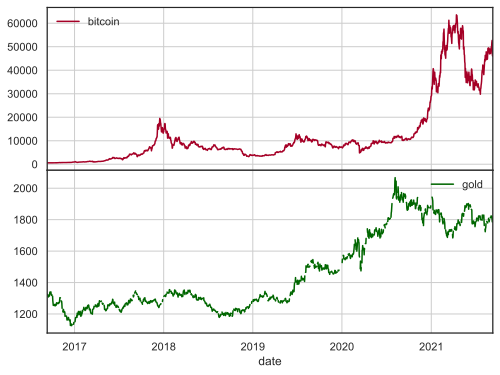

In [276]:
sns.set_theme(style="white", palette="pastel")
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6)) 
plt.subplots_adjust(hspace=0)  
data['bitcoin'].plot(kind='line', grid=True, colormap='RdYlGn', legend=True, ax=ax)
data['gold'].plot(kind='line', grid=True, color='#006600', legend=True, ax=ax2)
plt.savefig('./images/data.pdf', dpi=1000)
plt.savefig('./images/data.png', dpi=1000)

<AxesSubplot:xlabel='date'>

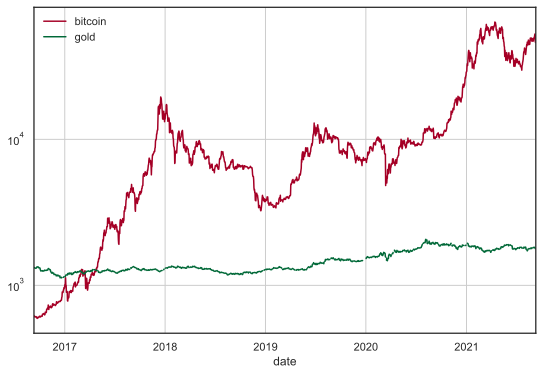

In [277]:
sns.set_theme(style="white", palette="pastel")
data.plot(kind='line', grid=True, colormap='RdYlGn',figsize=(9,6), legend=True, logy=True)
plt.savefig('./images/data2.png', dpi=1000)

<AxesSubplot:xlabel='date'>

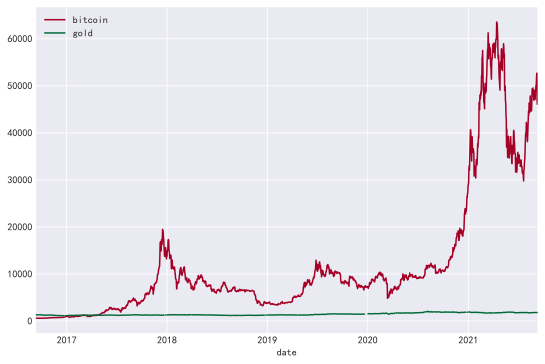

In [228]:
data.plot(kind='line', grid=True, colormap='RdYlGn',figsize=(9,6), legend=True)
plt.savefig('./images/data3.png', dpi=1000)

In [308]:
def plot_technical(df, name):
    # momentum
    momentum_period = 2 #参数
    df['MOM'] = df[name] - df[name].shift(periods=momentum_period) #shift直接算出动量

    # SMA
    simple_moving_period = 30
    df['SMA'] = df[name].rolling(window=simple_moving_period).mean() #pandas：直接rolling

    # EMA
    exp_moving_period = 30
    df['EMA'] = df[name].ewm(span=exp_moving_period).mean()

    # bollinger band
    Bolling_timeperiod = 5
    F_value_up = 2  
    F_value_down = 2 

    df['middleband'] = df[name].rolling(window=Bolling_timeperiod).mean() 
    std = df[name].rolling(window=Bolling_timeperiod).std(ddof=0) # 指明自由度为0，这样计算标准差时分母为N，与TA-Lib一致，如果不这样设置，我们计算标准差的公式分母是N-1。
    df['upperband'] = df['middleband'] + std * F_value_up #分别计算上下布林带
    df['lowerband'] = df['middleband'] - std * F_value_down
    return df

In [310]:
gold

,gold,MOM,SMA,EMA,middleband,upperband,lowerband
date,,,,,,,
2016-09-12,1324.60,NaN,NaN,1324.600000,NaN,NaN,NaN
2016-09-13,1323.65,NaN,NaN,1324.109167,NaN,NaN,NaN
2016-09-14,1321.75,-2.85,NaN,1323.269789,NaN,NaN,NaN
2016-09-15,1310.80,-12.85,NaN,1319.833908,NaN,NaN,NaN
2016-09-16,1308.35,-13.40,NaN,1317.221041,1317.83,1331.522713,1304.137287
...,...,...,...,...,...,...,...
2021-09-06,1821.60,9.05,1792.840000,1798.545321,1816.90,1826.593916,1807.206084
2021-09-07,1802.15,-21.55,1792.905000,1798.777881,1814.36,1829.814889,1798.905111
2021-09-08,1786.00,-35.60,1792.426667,1797.953501,1809.20,1836.958602,1781.441398


<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

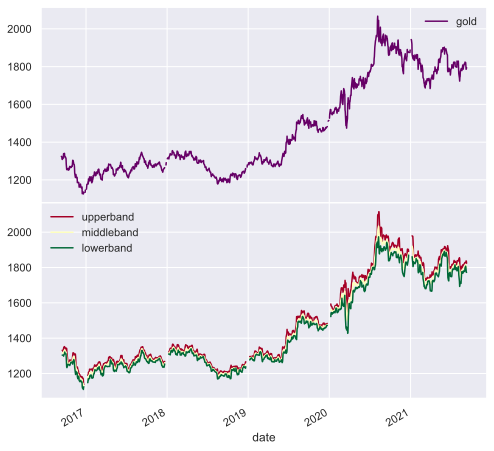

In [309]:
df = plot_technical(gold, 'gold')    

fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
df['gold'].plot(ax=ax, color="#660066", legend=True);
ax.grid(True) 
df[['upperband', 'middleband', 'lowerband']].plot(ax=ax1, colormap='RdYlGn');
ax1.grid(True)
plt.subplots_adjust(hspace=0)

<AxesSubplot:xlabel='date'>

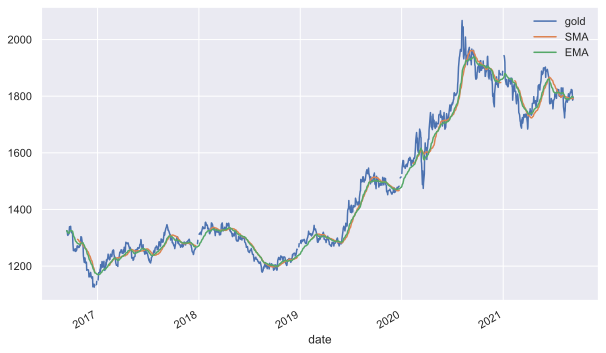

In [296]:
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(10,6))
# df[['close', 'SMA', 'EMA']].plot(ax=ax,legend=True, color=['#961a01', '#660066', '#173508']) 
# df[['close', 'SMA', 'EMA']].plot(ax=ax,legend=True, colormap='RdYlGn')
df[['gold', 'SMA', 'EMA']].plot(ax=ax,legend=True)
plt.savefig("./images/gold_EMA.pdf", dpi=1500)

<AxesSubplot:xlabel='date'>

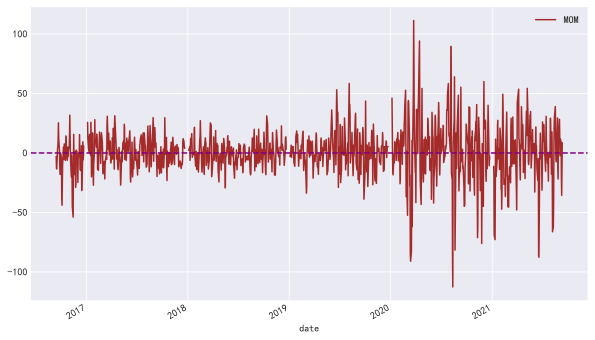

In [236]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
df[['MOM']].plot(ax=ax,legend=True, color='brown', grid=True)
ax.axhline(y=0, color='purple', linestyle='--')

<AxesSubplot:xlabel='date'>

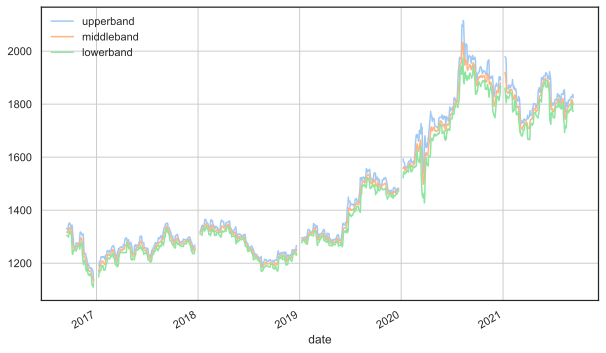

In [286]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
df[['upperband', 'middleband', 'lowerband']].plot(ax=ax)
ax.grid(True) 

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

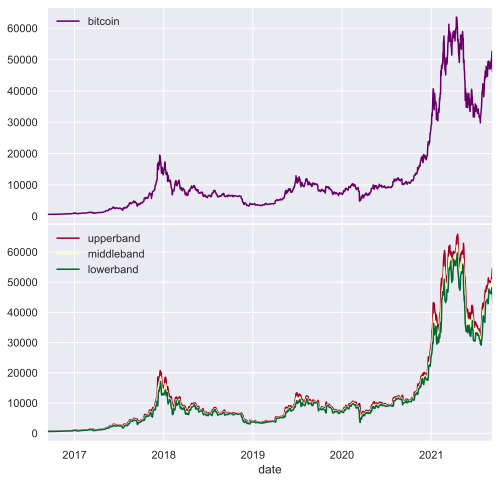

In [291]:
df = plot_technical(bitcoin, 'bitcoin')    

fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
df['bitcoin'].plot(ax=ax, color="#660066", legend=True);
ax.grid(True) 
df[['upperband', 'middleband', 'lowerband']].plot(ax=ax1, colormap='RdYlGn');
ax1.grid(True)
plt.subplots_adjust(hspace=0)

<AxesSubplot:xlabel='date'>

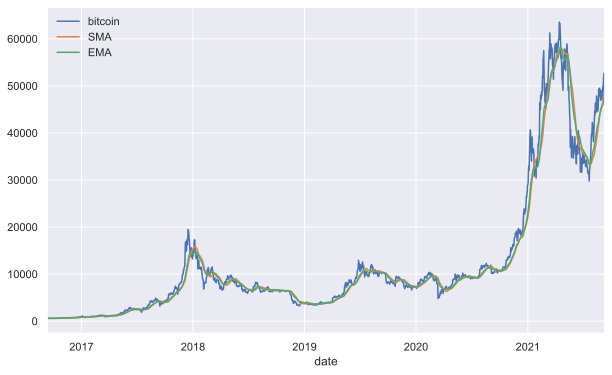

In [294]:
import seaborn as sns
sns.set_theme()
fig, ax = plt.subplots(1, 1, figsize=(10,6))
df[['bitcoin', 'SMA', 'EMA']].plot(ax=ax,legend=True)
plt.savefig("./images/bitcoin_EMA.pdf", dpi=1500)

<AxesSubplot:xlabel='date'>

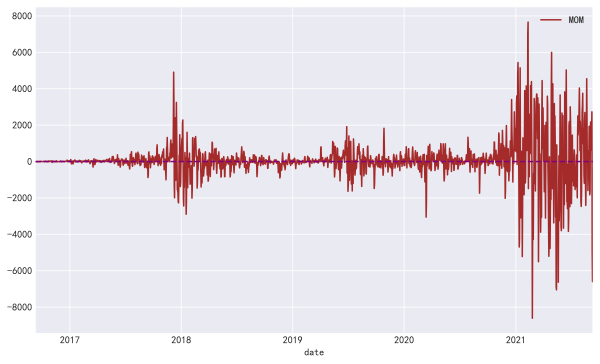

In [240]:
fig, ax = plt.subplots(1, 1, figsize=(10,6))
df[['MOM']].plot(ax=ax,legend=True, color='brown', grid=True)
ax.axhline(y=0, color='purple', linestyle='--')

<AxesSubplot:xlabel='date'>

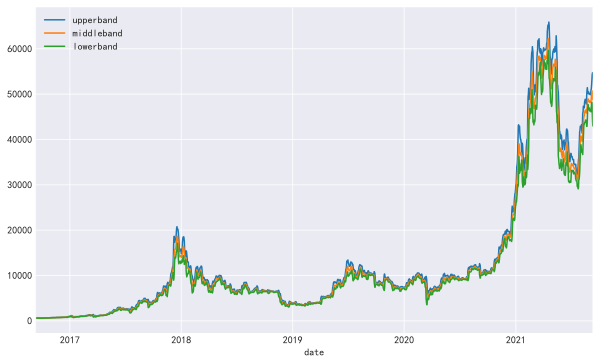

In [241]:
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(1, 1, 1)
df[['upperband', 'middleband', 'lowerband']].plot(ax=ax)
ax.grid(True) 

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

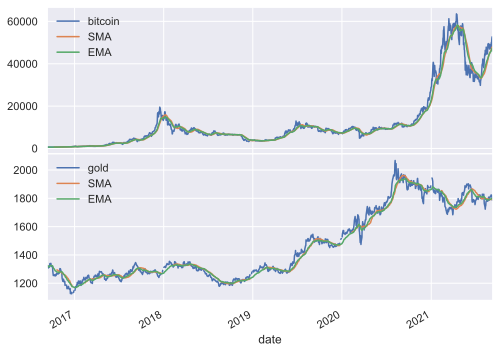

In [302]:
df1 = plot_technical(gold, 'gold')
df2 = plot_technical(bitcoin, 'bitcoin')
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6)) 
plt.subplots_adjust(hspace=0)  
df1[['gold', 'SMA', 'EMA']].plot(ax=ax2,legend=True)
df2[['bitcoin', 'SMA', 'EMA']].plot(ax=ax,legend=True)
plt.savefig("./images/EMA.png", dpi=1500)

<AxesSubplot:xlabel='date'>

<AxesSubplot:xlabel='date'>

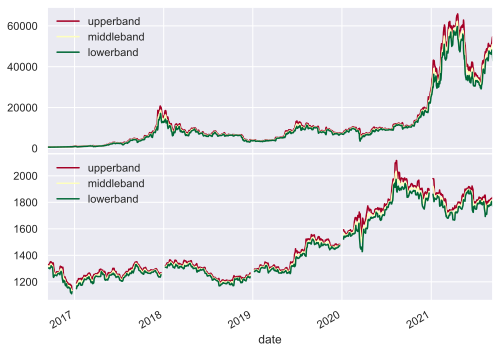

In [305]:
df1 = plot_technical(gold, 'gold')
df2 = plot_technical(bitcoin, 'bitcoin')
fig, (ax, ax2) = plt.subplots(2, 1, sharex=True, figsize=(8, 6)) 
plt.subplots_adjust(hspace=0)  
df1[['upperband', 'middleband', 'lowerband']].plot(ax=ax2, colormap='RdYlGn')
df2[['upperband', 'middleband', 'lowerband']].plot(ax=ax, colormap='RdYlGn')
plt.savefig("./images/bollinger.png", dpi=1500)

In [44]:
df = plot_technical(gold, 'gold')    

fig, (ax, ax1) = plt.subplots(2, 1, sharex=True, figsize=(8, 8))
df['gold'].plot(ax=ax, color="#660066", legend=True);
ax.grid(True) 
df[['upperband', 'middleband', 'lowerband']].plot(ax=ax1, colormap='RdYlGn')
ax1.grid(True)
plt.subplots_adjust(hspace=0)

参数平原

In [ ]:
def para_visualization_2(df, strategy_name, timing_stratey, select_stock_num, i, j):
    df['para1'] = df['para'].apply(lambda x: x[0])
    df['para2'] = df['para'].apply(lambda x: x[1])
    df['y'] = df[rank_name]

    # print(df)

    hot_df = df[['para1', 'para2', 'y']].copy()
    hot_df.set_index(['para1', 'para2'], inplace=True, drop=True)
    hot_df = hot_df.unstack()

    ax = plt.subplot(2, 1, 1 + i)
    ax.set_title(f"{strategy_name}-{timing_stratey}-选股数量{select_stock_num}-{rank_name}")
    sns.heatmap(hot_df, cmap='hot')

In [312]:
gold = pd.read_csv("./result/GFTD_signal_gold.csv")
gold

,parameter,cumulative_return,annual_return,max_drawdown,drawdown_begin,drawdown_end,return/drawdown,sharpe_ratio,base_return
0,"[11, 12, 2]",1.45,7.77%,-6.44%,2017-09-08 00:00:00,2018-09-27 00:00:00,1.21,1.063073,1.222932
1,"[15, 28, 2]",1.35,6.2%,-6.37%,2017-06-06 00:00:00,2017-07-11 00:00:00,0.97,0.940807,1.222932
2,"[15, 26, 2]",1.29,5.3%,-5.53%,2019-02-20 00:00:00,2019-04-23 00:00:00,0.96,0.962532,1.222932
3,"[11, 19, 2]",1.25,4.49%,-4.70%,2017-09-08 00:00:00,2018-09-27 00:00:00,0.95,0.897775,1.222932
4,"[11, 20, 2]",1.25,4.49%,-4.70%,2017-09-08 00:00:00,2018-09-27 00:00:00,0.95,0.897775,1.222932
...,...,...,...,...,...,...,...,...,...
2073,"[19, 9, 2]",0.85,-3.09%,-19.35%,2020-05-20 00:00:00,2021-03-30 00:00:00,-0.16,-0.286283,1.222932
2074,"[19, 10, 2]",0.85,-3.09%,-19.35%,2020-05-20 00:00:00,2021-03-30 00:00:00,-0.16,-0.286283,1.222932
2075,"[17, 17, 2]",0.82,-3.91%,-23.13%,2016-11-02 00:00:00,2021-03-30 00:00:00,-0.17,-0.401540,1.222932
2076,"[8, 2, 2]",0.96,-0.82%,-4.12%,2020-11-06 00:00:00,2021-09-10 00:00:00,-0.20,-0.453907,1.222932


In [317]:
gold['para1'] = gold['parameter'].apply(lambda x: eval(x)[0])
gold['para2'] = gold['parameter'].apply(lambda x: eval(x)[1])
gold

,parameter,cumulative_return,annual_return,max_drawdown,drawdown_begin,drawdown_end,return/drawdown,sharpe_ratio,base_return,para1,para2
0,"[11, 12, 2]",1.45,7.77%,-6.44%,2017-09-08 00:00:00,2018-09-27 00:00:00,1.21,1.063073,1.222932,11,12
1,"[15, 28, 2]",1.35,6.2%,-6.37%,2017-06-06 00:00:00,2017-07-11 00:00:00,0.97,0.940807,1.222932,15,28
2,"[15, 26, 2]",1.29,5.3%,-5.53%,2019-02-20 00:00:00,2019-04-23 00:00:00,0.96,0.962532,1.222932,15,26
3,"[11, 19, 2]",1.25,4.49%,-4.70%,2017-09-08 00:00:00,2018-09-27 00:00:00,0.95,0.897775,1.222932,11,19
4,"[11, 20, 2]",1.25,4.49%,-4.70%,2017-09-08 00:00:00,2018-09-27 00:00:00,0.95,0.897775,1.222932,11,20
...,...,...,...,...,...,...,...,...,...,...,...
2073,"[19, 9, 2]",0.85,-3.09%,-19.35%,2020-05-20 00:00:00,2021-03-30 00:00:00,-0.16,-0.286283,1.222932,19,9
2074,"[19, 10, 2]",0.85,-3.09%,-19.35%,2020-05-20 00:00:00,2021-03-30 00:00:00,-0.16,-0.286283,1.222932,19,10
2075,"[17, 17, 2]",0.82,-3.91%,-23.13%,2016-11-02 00:00:00,2021-03-30 00:00:00,-0.17,-0.401540,1.222932,17,17
2076,"[8, 2, 2]",0.96,-0.82%,-4.12%,2020-11-06 00:00:00,2021-09-10 00:00:00,-0.20,-0.453907,1.222932,8,2


<Figure size 864x576 with 0 Axes>

<AxesSubplot:xlabel='None-n2', ylabel='n1'>

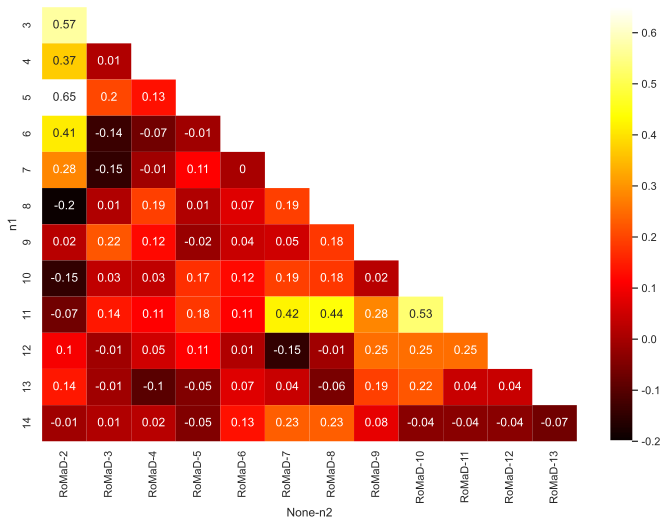

In [349]:
sns.set_theme(style="white")
gold = pd.read_csv("./result/GFTD_signal_gold.csv")
gold['para1'] = gold['parameter'].apply(lambda x: eval(x)[0])
gold['para2'] = gold['parameter'].apply(lambda x: eval(x)[1])
hot_gold = gold[['para1', 'para2', 'return/drawdown']].copy()
hot_gold.rename(columns={'return/drawdown': "RoMaD", "para1": "n1", "para2": "n2"}, inplace=True)
hot_gold.set_index(['n1', 'n2'], inplace=True, drop=True)
hot_gold = hot_gold.unstack()
plt.figure(figsize=(12,8))
sns.heatmap(hot_gold, cmap='hot',annot=True)
plt.savefig("./images/gftd_heat3.png", dpi=1000)

In [328]:
bitcoin

,parameter,cumulative_return,annual_return,max_drawdown,drawdown_begin,drawdown_end,return/drawdown,sharpe_ratio,base_return,para1,para2
0,"[4, 4, 2]",157.94,175.23%,-48.46%,2018-05-05 00:00:00,2019-02-08 00:00:00,3.62,1.635506,74.589705,4,4
1,"[3, 3, 2]",93.55,147.86%,-49.45%,2021-02-22 00:00:00,2021-07-21 00:00:00,2.99,1.519407,74.589705,3,3
2,"[4, 3, 2]",74.63,136.91%,-50.92%,2021-03-14 00:00:00,2021-07-23 00:00:00,2.69,1.461917,74.589705,4,3
3,"[5, 4, 3]",143.24,169.91%,-67.45%,2018-05-05 00:00:00,2019-02-08 00:00:00,2.52,1.634031,74.589705,5,4
4,"[6, 6, 3]",130.22,164.81%,-65.44%,2017-12-16 00:00:00,2019-02-08 00:00:00,2.52,1.545538,74.589705,6,6
...,...,...,...,...,...,...,...,...,...,...,...
91,"[3, 6, 4]",1.10,2.02%,-62.06%,2018-03-05 00:00:00,2019-12-18 00:00:00,0.03,0.217264,74.589705,3,6
92,"[4, 5, 6]",0.97,-0.69%,-71.85%,2018-03-05 00:00:00,2018-12-15 00:00:00,-0.01,0.207011,74.589705,4,5
93,"[5, 6, 6]",0.73,-6.23%,-71.85%,2018-03-05 00:00:00,2018-12-15 00:00:00,-0.09,0.148187,74.589705,5,6
94,"[4, 6, 6]",0.70,-6.9%,-71.85%,2018-03-05 00:00:00,2018-12-15 00:00:00,-0.10,0.136988,74.589705,4,6


<Figure size 864x576 with 0 Axes>

<AxesSubplot:xlabel='None-n2', ylabel='n1'>

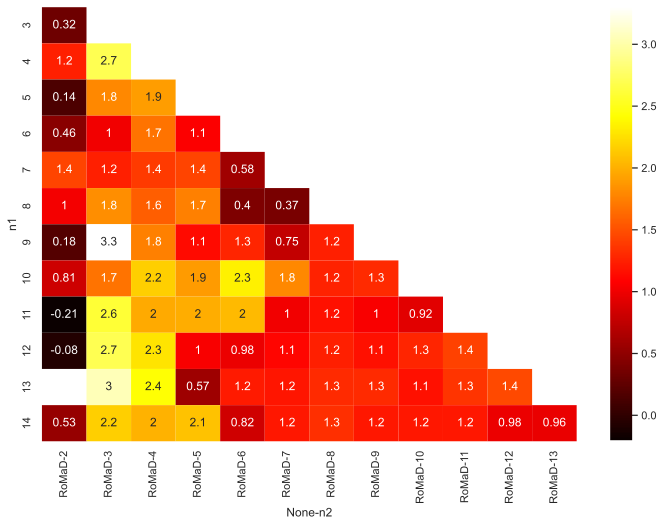

In [351]:
bitcoin = pd.read_csv("./result/GFTD_signal_bitcoin.csv")
bitcoin['para1'] = bitcoin['parameter'].apply(lambda x: eval(x)[0])
bitcoin['para2'] = bitcoin['parameter'].apply(lambda x: eval(x)[1])
hot_bitcoin = bitcoin[['para1', 'para2', 'return/drawdown']].copy()
hot_bitcoin.rename(columns={'return/drawdown': "RoMaD", "para1": "n1", "para2": "n2"}, inplace=True)
hot_bitcoin.set_index(['n1', 'n2'], inplace=True, drop=True)
hot_bitcoin = hot_bitcoin.unstack()
plt.figure(figsize=(12,8))
sns.heatmap(hot_bitcoin, cmap='hot',annot=True)
plt.savefig("./images/gftd_heat_bitcoin.png", dpi=1000)

In [379]:
gold = pd.read_csv("./raw_data/LBMA-GOLD.csv")
bitcoin = pd.read_csv("./raw_data/BCHAIN-MKPRU.csv")


In [380]:
def f(x):
    a = np.random.random()
    b = np.random.random()
    if a > 0.5:
        x += b/1000*1
    else:
        x -= b/1000*1
    return x

gold_copy = gold.copy()
gold_copy['USD (PM)'] = gold_copy['USD (PM)'].apply(f)
gold_copy.to_csv("./raw_data/LBMA-GOLD1.csv", index=False)

bitcoin_copy = bitcoin.copy()
bitcoin_copy['Value'] = bitcoin_copy['Value'].apply(f)
bitcoin_copy.to_csv("./raw_data/BCHAIN-MKPRU1.csv", index=False)

In [371]:
bitcoin

,Date,Value
0,9/11/16,621.65
1,9/12/16,609.67
2,9/13/16,610.92
3,9/14/16,608.82
4,9/15/16,610.38
...,...,...
1821,9/6/21,51769.06
1822,9/7/21,52677.40
1823,9/8/21,46809.17
1824,9/9/21,46078.38


,Date,USD (PM)
0,9/12/16,1324.599765
1,9/13/16,1323.650682
2,9/14/16,1321.749008
3,9/15/16,1310.800536
4,9/16/16,1308.349594
...,...,...
1260,9/6/21,1821.600299
1261,9/7/21,1802.150656
1262,9/8/21,1785.999324
1263,9/9/21,1788.249973
